## Cookie Cats и цель проекта

**Cookie Cats** — чрезвычайно популярная мобильная игра-головоломка, разработанная Tactile Entertainment. Это классическая игра-головоломка в стиле «соедини три», в которой игрок должен соединять плитки одного цвета, чтобы очистить игровое поле и выиграть уровень.

<img src="maxresdefault.jpg" width="500" height="300">

По мере прохождения уровней игры игроки время от времени сталкиваются с воротами, которые заставляют их ждать нетривиальное количество времени или совершать покупки в приложении для продвижения. Помимо стимулирования покупок в приложении, эти ворота служат важной цели: дать игрокам вынужденный перерыв в игре, что, как мы надеемся, приведет к увеличению и продлению удовольствия игрока от игры.

<img src="cc_gates.png" width="500" height="300">

**Но где должны быть расположены ворота?** Изначально первые ворота были размещены на уровне 30, но в этом эксперименте мы собираемся проанализировать AB-тест, в котором мы переместили первые ворота в Cookie Cats с уровня 30 на уровень 40. В частности, мы рассмотрим влияние на удержание игроков. Но прежде чем мы доберемся до этого, ключевым шагом перед проведением любого анализа является понимание данных.

## Набор данных и переменные

У нас есть данные о 90 189 игроках, которые установили игру во время проведения AB-теста. 

* userid — уникальный номер, идентифицирующий каждого игрока.

* version - попал ли игрок в контрольную группу (gate_30 - ворота 30 уровня) или группу с перенесенными воротами (gate_40 - ворота 40 уровня).

* sum_gamerounds — количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.

* retention_1 - вернулся ли игрок и играл через 1 день после установки?

* retention_7 -  вернулся ли игрок и играл через 7 дней после установки?

Когда игрок устанавливал игру, ему или ей случайным образом присваивались gate_30 или gate_40.


In [1]:
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd


from matplotlib import pyplot as plt

import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [2]:
df = pd.read_csv('result_cookie_cats.csv')
df.sample(10)

,userid,version,sum_gamerounds,retention_1,retention_7
9592,1055169,gate_30,3,0,0
7887,869291,gate_40,28,1,0
60650,6718169,gate_40,5,0,0
7031,779585,gate_40,115,1,1
54393,6038125,gate_30,1,0,0
51360,5693678,gate_30,29,0,0
51293,5686455,gate_40,7,0,0
11001,1215952,gate_40,4,0,0
24358,2709183,gate_40,163,1,1
15010,1664682,gate_30,23,1,0


In [3]:
df.shape[0] # количество наблюдений

90189

In [4]:
df.userid.nunique() # количество уникальных игроков

90189

In [5]:
df.groupby(['version'])[['userid']].nunique()

,userid
version,
gate_30,44700
gate_40,45489


**В данных нет дубликатов и в каждой группе примерно равное количество игроков**

Посмотрим, как вели себя игроки после установки игры:

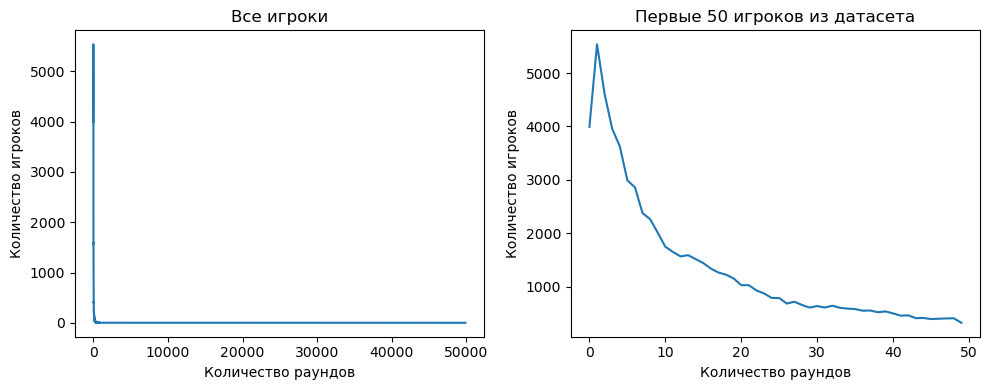

In [6]:
behavior_users = df.groupby(['sum_gamerounds'])['userid'].count()

fig, (ax_plot, ay_plot) = plt.subplots(1, 2, figsize=(10, 4))

ax_plot.set_title('Все игроки')
behavior_users.plot(ax=ax_plot)
ax_plot.set_xlabel('Количество раундов')
ax_plot.set_ylabel('Количество игроков')

ay_plot.set_title('Первые 50 игроков из датасета')
behavior_users.head(50).plot(ax=ay_plot)
ay_plot.set_xlabel('Количество раундов')
ay_plot.set_ylabel('Количество игроков')

plt.tight_layout()
plt.show();

Из графика очевидно, что много игроков установили игру, но так и не играли. Рассчитаем их количество:

In [7]:
df[df.sum_gamerounds == 0]['userid'].count()

3994

Посмотрим какие доли игроков у нас возвращаются в игру через 1 и 7 дней после установки:

In [8]:
ret_1_mean = df.retention_1.mean()
ret_7_mean = df.retention_7.mean()

print(f'{ret_1_mean=:.3f}, {ret_7_mean=:.3f}')

ret_1_mean=0.445, ret_7_mean=0.186


Спустя 1 день после установки возвращается почти 45% игроков, спустя 7 дней почти 19% игроков.

Посмотрим какие у нас различия в группах:

In [9]:
share_retention = df.groupby(['version']).agg({'userid': 'count', 'retention_1': 'mean', 
                                                   'retention_7': 'mean', 'sum_gamerounds': 'sum'})
share_retention

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


В группах есть небольшие различия, в группе gate_40 доля игроков незначительно, но меньше, чем в группе gate_30. 

Посмотрим на статическую значимость этих различий:

In [10]:
group_30_ret_1 = df[df.version == 'gate_30']['retention_1'].values
group_40_ret_1 = df[df.version == 'gate_40']['retention_1'].values

group_30_ret_7 = df[df.version == 'gate_30']['retention_7'].values
group_40_ret_7 = df[df.version == 'gate_40']['retention_7'].values

In [11]:
result_1 = bs.bootstrap_ab(group_30_ret_1, group_40_ret_1, stat_func=bs_stats.mean,
                    compare_func=bs_compare.difference, alpha=0.05, num_iterations=500)

print(f'Доверительный интервал retention_1: {round(result_1.lower_bound, 5)} - {round(result_1.upper_bound, 5)}')

result_7 = bs.bootstrap_ab(group_30_ret_7, group_40_ret_7, stat_func=bs_stats.mean,
                           compare_func=bs_compare.difference, alpha=0.05, num_iterations=500)

print(f'Доверительный интервал retention_7: {round(result_7.lower_bound, 5)} - {round(result_7.upper_bound, 5)}')

Доверительный интервал retention_1: 3e-05 - 0.01202
Доверительный интервал retention_7: 0.0033 - 0.01324


Из расчета мы видим, что доверительный интервал проходит через ноль для 1-дневного удержания, что говорит о том, что нет статистически значимых различий, в 7-дневном удержании доверетильный интервал не проходит через ноль, таким образом есть статитстически значимые различия. 

Рассмотрим также критерий Хи-квадрат для расчета статистической значимости:

In [12]:
frequency_retention = df.groupby(['version']).agg({'userid': 'count', 'retention_1': 'sum', 
                                                   'retention_7': 'sum', 'sum_gamerounds': 'sum'})
frequency_retention

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,20034,8502,2344795
gate_40,45489,20119,8279,2333530


In [13]:
m_A_1, m_B_1 = frequency_retention.retention_1
m_A_7, m_B_7 = frequency_retention.retention_7

n_A, n_B = frequency_retention.userid

stat_1, p_value_1, _, _ = chi2_contingency([[m_A_1, n_A-m_A_1], [m_B_1, n_B - m_B_1]], correction=False)
stat_7, p_value_7, _, _ = chi2_contingency([[m_A_7, n_A-m_A_7], [m_B_7, n_B - m_B_7]], correction=False)

print(f'{stat_1 = :.4f}, {p_value_1 = :.4f}')
print(f'{stat_7 = :.4f}, {p_value_7 = :.4f}')

stat_1 = 3.1830, p_value_1 = 0.0744
stat_7 = 10.0132, p_value_7 = 0.0016


Получили такие же результаты, как и в предыдущем расчете: нет статитстически значимых различий для 1-дневного удержания, а для 7-дневного удержания p_value = 0.0016 < 0.05 => есть статистически значимые различия.

В группе, где ворота стоят на 30 уровне возвращаются в игру на 223 игрока больше, чем в группе, где ворота стоят на 40 уровне. 

**Таким образом, если мы хотим поддерживать высокий уровень удержания как на 1 день, так и на 7, то не стоит перемещать ворота на 40 уровень.**

<img src="ziggy_smiling.png" width="150" height="70">

Проверим также мощность наших тестов (вероятность обнаружить статистически значимую разницу или эффект, если он действительно существуeт):

In [31]:
import math
import statsmodels.stats.power as smp
alpha = 0.05
n = n_A
p_1 = share_retention.retention_1[0]
p_2 = share_retention.retention_1[1]

effect = 2*math.asin(np.sqrt(p_1)) - 2*math.asin(np.sqrt(p_2))

power = smp.zt_ind_solve_power(effect_size=effect, nobs1=n, alpha=alpha, alternative='two-sided')
power

0.4272451872776839

In [32]:
p_1 = share_retention.retention_7[0]
p_2 = share_retention.retention_7[1]

effect = 2*math.asin(np.sqrt(p_1)) - 2*math.asin(np.sqrt(p_2))

power = smp.zt_ind_solve_power(effect_size=effect, nobs1=n, alpha=alpha, alternative='two-sided')
power

0.8830912109776261

Для 1-дневного удержания получили низкую вероятность (43%) обнаружить разницу в группах, а для 7-дневного удержания мощность составляет 88%, таким образом для показателя 1-дневного удержания необходимо увеличить выборку.

In [35]:
p_1 = share_retention.retention_1[0]
p_2 = share_retention.retention_1[1]

effect = 2*math.asin(np.sqrt(p_1)) - 2*math.asin(np.sqrt(p_2))

n = smp.zt_ind_solve_power(effect_size=effect, power=0.80, alpha=alpha, alternative='two-sided')
print(f'Необходимый размер выборки {round(n)}')

Необходимый размер выборки 111190
